In [ ]:
# !pip install xgboost

In [ ]:
# !pip install lightgbm

In [ ]:
# !pip install imblearn


SLEEP HEALTH MACHINE LEARNING MODELS (PART 4)

1. DATA PREPARATION (Loading from Part 2)
✓ Successfully loaded ML-ready data and feature lists from Part 2.
Data shapes loaded:
  X_quality (Regression Features):   (400, 27)
  y_quality (Regression Target):   (400,)
  X_disorder (Classif. Features): (400, 27)
  y_disorder (Classif. Target):  (400,)

2. TASK 1: SLEEP QUALITY PREDICTION (REGRESSION)

Training set: 320 samples
Test set: 80 samples

Training Regression Models...
--------------------------------------------------------------------------------

Linear Regression:
  RMSE: 0.5642
  MAE:  0.3816
  R²:   0.9183

Ridge Regression:
  RMSE: 0.5622
  MAE:  0.3760
  R²:   0.9189

Random Forest:
  RMSE: 0.3379
  MAE:  0.2394
  R²:   0.9707

XGBoost:
  RMSE: 0.3650
  MAE:  0.2628
  R²:   0.9658

BEST REGRESSION MODEL: Random Forest (R² = 0.9707)


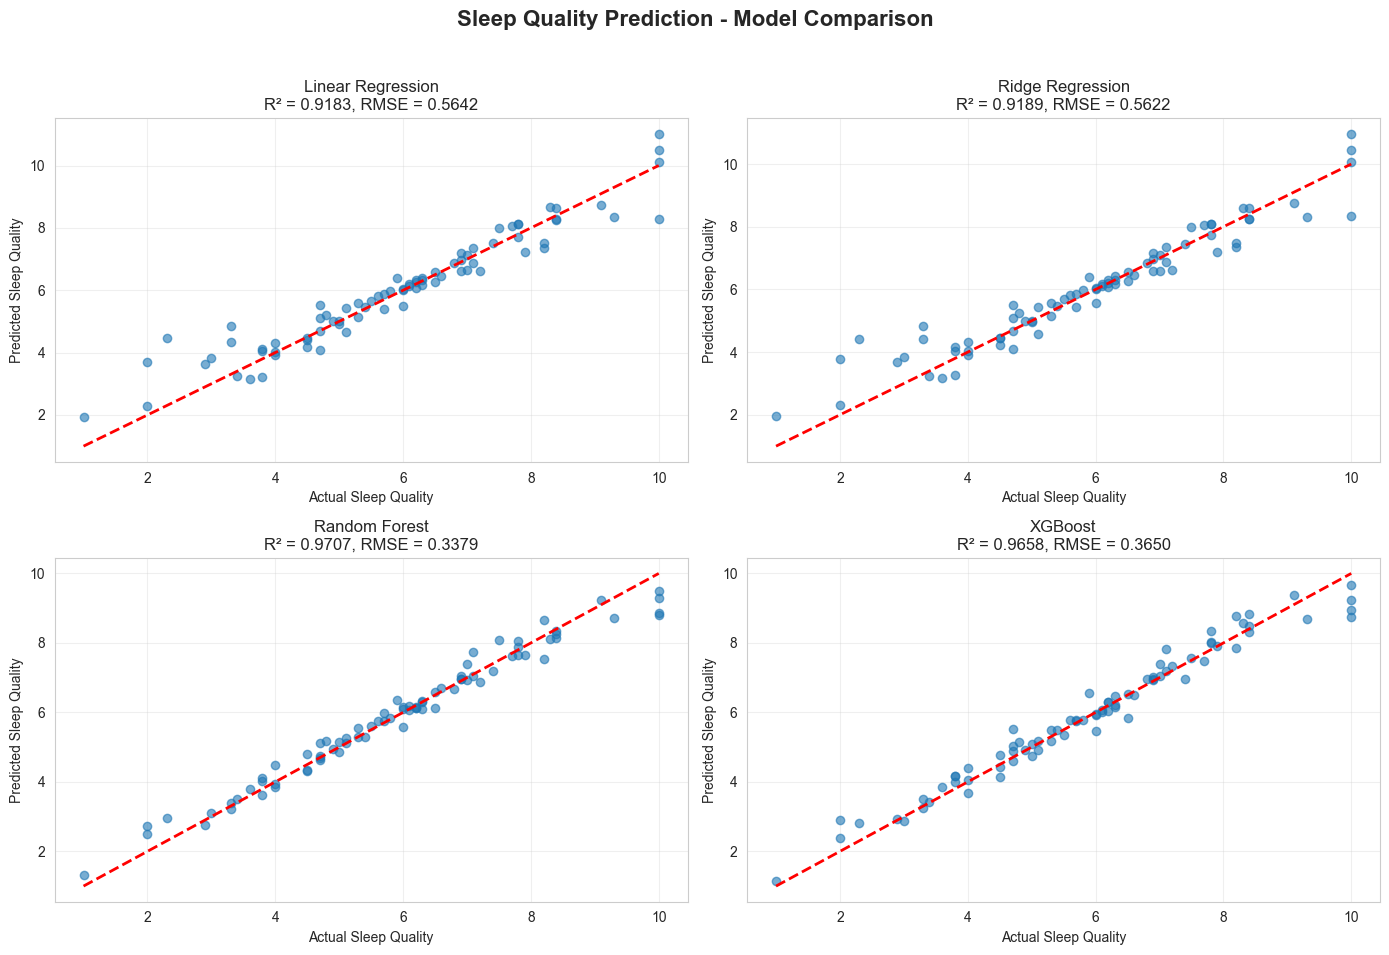


3. TASK 2: SLEEP DISORDER PREDICTION (MULTI-CLASS CLASSIFICATION)

Target variable encoded. Classes: ['Insomnia', 'Sleep Apnea', nan]

Class Distribution (Original):
Sleep Disorder
Insomnia       79
Sleep Apnea    31
Name: count, dtype: int64

Applying SMOTE for class balancing...
Original training set: 320 samples
Balanced training set: 696 samples

Training Classification Models...
--------------------------------------------------------------------------------

Logistic Regression:
  Accuracy:  0.8625
  Precision: 0.8544
  Recall:    0.8625
  F1-Score:  0.8583

Random Forest:
  Accuracy:  0.8875
  Precision: 0.8618
  Recall:    0.8875
  F1-Score:  0.8736

XGBoost:
  Accuracy:  0.8625
  Precision: 0.8544
  Recall:    0.8625
  F1-Score:  0.8583

LightGBM:
  Accuracy:  0.8750
  Precision: 0.8583
  Recall:    0.8750
  F1-Score:  0.8662

BEST CLASSIFICATION MODEL: Random Forest (F1 = 0.8736)

Detailed Classification Report - Random Forest:
-----------------------------------------------

TypeError: object of type 'float' has no len()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score,
                             mean_squared_error, r2_score, mean_absolute_error)

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

print("=" * 80)
print("SLEEP HEALTH MACHINE LEARNING MODELS (PART 4)")
print("=" * 80)

# ===========================
# 1. PREPARE DATA FOR ML
# ===========================
# ### [CORRECTED] ###
# We load the files we created in Part 2. This is MUCH cleaner
# and avoids all the re-encoding and data leakage bugs.

print("\n" + "=" * 80)
print("1. DATA PREPARATION (Loading from Part 2)")
print("=" * 80)

try:
    # Load the fully scaled, one-hot encoded ML data
    # D:\GIT_HUB\12_Final_Projects_of_all\01_Analysis\Dataset\sleep_health_ml_ready_full.csv
    df_ml = pd.read_csv('D:\\GIT_HUB\\12_Final_Projects_of_all\\01_Analysis\\Dataset\\sleep_health_ml_ready_full.csv')
    
    # Load the exact feature lists we saved
    feature_list_quality = pd.read_csv('D:\\GIT_HUB\\12_Final_Projects_of_all\\01_Analysis\\Dataset\\feature_names_quality.csv')['feature'].tolist()
    feature_list_disorder = pd.read_csv('D:\\GIT_HUB\\12_Final_Projects_of_all\\01_Analysis\\Dataset\\feature_names_disorder.csv')['feature'].tolist()
    
    print("✓ Successfully loaded ML-ready data and feature lists from Part 2.")
except FileNotFoundError:
    print("ERROR: ML-ready files from Part 2 not found.")
    print("Please run the Part 2 (Preprocessing) script first.")
    df_ml = pd.DataFrame() # Stop script if files are missing

if not df_ml.empty:

    # --- Define all our X and y variables for both tasks ---
    
    # Task 1: Sleep Quality (Regression)
    # X_quality is all features from our saved list
    X_quality = df_ml[feature_list_quality]
    # y_quality is the original, continuous target variable
    y_quality = df_ml['Quality of Sleep']

    # Task 2: Sleep Disorder (Classification)
    # X_disorder is all features from its saved list (no leaks)
    X_disorder = df_ml[feature_list_disorder]
    # y_disorder is the *string* target. We will encode this next.
    y_disorder_str = df_ml['Sleep Disorder']

    print(f"Data shapes loaded:")
    print(f"  X_quality (Regression Features):   {X_quality.shape}")
    print(f"  y_quality (Regression Target):   {y_quality.shape}")
    print(f"  X_disorder (Classif. Features): {X_disorder.shape}")
    print(f"  y_disorder (Classif. Target):  {y_disorder_str.shape}")

    # ===========================
    # 2. TASK 1: SLEEP QUALITY PREDICTION (REGRESSION)
    # ===========================

    print("\n" + "=" * 80)
    print("2. TASK 1: SLEEP QUALITY PREDICTION (REGRESSION)")
    print("=" * 80)

    # Use the variables we just defined
    X_train, X_test, y_train, y_test = train_test_split(X_quality, y_quality, test_size=0.2, random_state=42)

    print(f"\nTraining set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Models to compare
    regression_models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    }

    regression_results = {}

    print("\nTraining Regression Models...")
    print("-" * 80)

    for name, model in regression_models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        
        # Metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        regression_results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'model': model
        }
        
        print(f"\n{name}:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  R²:   {r2:.4f}")

    # Best model
    best_reg_model = max(regression_results.items(), key=lambda x: x[1]['R2'])
    print(f"\n{'='*80}")
    print(f"BEST REGRESSION MODEL: {best_reg_model[0]} (R² = {best_reg_model[1]['R2']:.4f})")
    print(f"{'='*80}")

    # Visualize regression results
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Sleep Quality Prediction - Model Comparison', fontsize=16, fontweight='bold')

    for idx, (name, results) in enumerate(list(regression_results.items())[:4]):
        row = idx // 2
        col = idx % 2
        
        model = results['model']
        y_pred = model.predict(X_test)
        
        axes[row, col].scatter(y_test, y_pred, alpha=0.6)
        axes[row, col].plot([y_test.min(), y_test.max()],
                            [y_test.min(), y_test.max()],
                            'r--', lw=2)
        axes[row, col].set_xlabel('Actual Sleep Quality')
        axes[row, col].set_ylabel('Predicted Sleep Quality')
        axes[row, col].set_title(f'{name}\nR² = {results["R2"]:.4f}, RMSE = {results["RMSE"]:.4f}')
        axes[row, col].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

    # ===========================
    # 3. TASK 2: SLEEP DISORDER PREDICTION (CLASSIFICATION)
    # ===========================

    print("\n" + "=" * 80)
    print("3. TASK 2: SLEEP DISORDER PREDICTION (MULTI-CLASS CLASSIFICATION)")
    print("=" * 80)

    # ### [CORRECTED] ###
    # We must encode our string target variable 'y_disorder_str'
    le_disorder = LabelEncoder()
    y_disorder_encoded = le_disorder.fit_transform(y_disorder_str)
    
    print(f"\nTarget variable encoded. Classes: {list(le_disorder.classes_)}")

    X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
        X_disorder, y_disorder_encoded, test_size=0.2, random_state=42, stratify=y_disorder_encoded
    )

    print(f"\nClass Distribution (Original):")
    print(y_disorder_str.value_counts())

    # Handle class imbalance with SMOTE
    print("\nApplying SMOTE for class balancing...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_d, y_train_d)

    print(f"Original training set: {X_train_d.shape[0]} samples")
    print(f"Balanced training set: {X_train_balanced.shape[0]} samples")

    # Classification models
    classification_models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
        'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
    }

    classification_results = {}

    print("\nTraining Classification Models...")
    print("-" * 80)

    for name, model in classification_models.items():
        # Train model
        model.fit(X_train_balanced, y_train_balanced)
        
        # Predictions
        y_pred = model.predict(X_test_d)
        
        # Metrics
        accuracy = accuracy_score(y_test_d, y_pred)
        precision = precision_score(y_test_d, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test_d, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test_d, y_pred, average='weighted', zero_division=0)
        
        classification_results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'model': model
        }
        
        print(f"\n{name}:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")

    # Best classification model
    best_class_model = max(classification_results.items(), key=lambda x: x[1]['F1-Score'])
    print(f"\n{'='*80}")
    print(f"BEST CLASSIFICATION MODEL: {best_class_model[0]} (F1 = {best_class_model[1]['F1-Score']:.4f})")
    print(f"{'='*80}")

    # Detailed classification report for best model
    print(f"\nDetailed Classification Report - {best_class_model[0]}:")
    print("-" * 80)
    best_model = best_class_model[1]['model']
    y_pred_best = best_model.predict(X_test_d)
    print(classification_report(y_test_d, y_pred_best,
                                target_names=le_disorder.classes_))

    # Confusion Matrix
    
    cm = confusion_matrix(y_test_d, y_pred_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le_disorder.classes_,
                yticklabels=le_disorder.classes_)
    plt.title(f'Confusion Matrix - {best_class_model[0]}', fontsize=14, fontweight='bold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

    # ===========================
    # 4. FEATURE IMPORTANCE ANALYSIS
    # ===========================

    print("\n" + "=" * 80)
    print("4. FEATURE IMPORTANCE ANALYSIS")
    print("=" * 80)

    # Get feature importance from best models
    if hasattr(best_reg_model[1]['model'], 'feature_importances_'):
        # ### [CORRECTED] ###
        # Use the correct feature list we loaded in Section 1
        reg_importance = pd.DataFrame({
            'Feature': feature_list_quality, 
            'Importance': best_reg_model[1]['model'].feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print(f"\nTop Features for Sleep Quality Prediction ({best_reg_model[0]}):")
        print(reg_importance.head(10))
        
        # Plot
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=reg_importance.head(10), x='Importance', y='Feature', palette='viridis')
        plt.title(f'Top 10 Features - Sleep Quality Prediction ({best_reg_model[0]})',
                  fontsize=14, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    if hasattr(best_class_model[1]['model'], 'feature_importances_'):
        # ### [CORRECTED] ###
        # Use the correct feature list we loaded in Section 1
        class_importance = pd.DataFrame({
            'Feature': feature_list_disorder, 
            'Importance': best_class_model[1]['model'].feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print(f"\nTop Features for Sleep Disorder Prediction ({best_class_model[0]}):")
        print(class_importance.head(10))
        
        # Plot
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=class_importance.head(10), x='Importance', y='Feature', palette='rocket')
        plt.title(f'Top 10 Features - Sleep Disorder Prediction ({best_class_model[0]})',
                  fontsize=14, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    # ===========================
    # 5. MODEL COMPARISON VISUALIZATION
    # ===========================

    print("\n" + "=" * 80)
    print("5. MODEL COMPARISON SUMMARY")
    print("=" * 80)

    # Regression models comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # R² scores
    reg_names = list(regression_results.keys())
    r2_scores = [regression_results[name]['R2'] for name in reg_names]
    axes[0].barh(reg_names, r2_scores, color='skyblue')
    axes[0].set_xlabel('R² Score')
    axes[0].set_title('Regression Models - R² Comparison', fontweight='bold')
    axes[0].axvline(0.8, color='red', linestyle='--', label='Good Performance')
    axes[0].legend()

    # Classification F1 scores
    class_names = list(classification_results.keys())
    f1_scores = [classification_results[name]['F1-Score'] for name in class_names]
    axes[1].barh(class_names, f1_scores, color='lightcoral')
    axes[1].set_xlabel('F1-Score')
    axes[1].set_title('Classification Models - F1 Score Comparison', fontweight='bold')
    axes[1].axvline(0.8, color='red', linestyle='--', label='Good Performance')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # ===========================
    # 6. SAVE MODELS & PREDICTIONS
    # ===========================

    print("\n" + "=" * 80)
    print("6. SAVING MODELS & PREDICTIONS")
    print("=" * 80)

    # Save best regression model
    with open('sleep_quality_model.pkl', 'wb') as f:
        pickle.dump(best_reg_model[1]['model'], f)
    print("✓ Sleep Quality model saved: sleep_quality_model.pkl")

    # Save best classification model
    with open('sleep_disorder_model.pkl', 'wb') as f:
        pickle.dump(best_class_model[1]['model'], f)
    print("✓ Sleep Disorder model saved: sleep_disorder_model.pkl")
    
    # Save the label encoder
    with open('disorder_label_encoder.pkl', 'wb') as f:
        pickle.dump(le_disorder, f)
    print("✓ Disorder Label Encoder saved: disorder_label_encoder.pkl")


    # --- Generate predictions for the *original* processed file ---
    # We load the "human-readable" file from Part 2 for this.
    df_viz = pd.read_csv('D:\\GIT_HUB\\12_Final_Projects_of_all\\01_Analysis\\Dataset\\sleep_health_processed_for_viz.csv')

    # ### [CORRECTED] ###
    # We must predict on the *same data* the model was trained on.
    # We use our `X_quality` and `X_disorder` DataFrames which are 
    # aligned with the `df_viz` file's rows.
    
    df_viz['Predicted_Sleep_Quality'] = best_reg_model[1]['model'].predict(X_quality)
    
    # Predict encoded labels
    predicted_labels = best_class_model[1]['model'].predict(X_disorder)
    # Inverse transform to get string names
    df_viz['Predicted_Disorder'] = le_disorder.inverse_transform(predicted_labels)

    # Add prediction confidence scores
    disorder_proba = best_class_model[1]['model'].predict_proba(X_disorder)
    df_viz['Disorder_Confidence'] = disorder_proba.max(axis=1) * 100

    # ### [CORRECTED] ###
    # Fixed the logic of the labels. 0-50 is Low Risk, 75-100 is High Risk.
    df_viz['Risk_Level'] = pd.cut(df_viz['Disorder_Confidence'],
                                  bins=[0, 50, 75, 100],
                                  labels=['Low_Risk', 'Medium_Risk', 'High_Risk'],
                                  right=True)

    # Save enhanced dataset
    df_viz.to_csv('D:\\GIT_HUB\\12_Final_Projects_of_all\\01_Analysis\\Dataset\\sleep_health_with_predictions.csv', index=False)
    print("✓ Dataset with predictions saved: sleep_health_with_predictions.csv")

    # ===========================
    # 7. FINAL SUMMARY
    # ===========================

    print("\n" + "=" * 80)
    print("MACHINE LEARNING SUMMARY")
    print("=" * 80)

    print(f"""
    REGRESSION TASK (Sleep Quality Prediction):
      Best Model: {best_reg_model[0]}
      R² Score: {best_reg_model[1]['R2']:.4f}
      RMSE: {best_reg_model[1]['RMSE']:.4f}
      MAE: {best_reg_model[1]['MAE']:.4f}

    CLASSIFICATION TASK (Sleep Disorder Prediction):
      Best Model: {best_class_model[0]}
      Accuracy: {best_class_model[1]['Accuracy']:.4f}
      F1-Score: {best_class_model[1]['F1-Score']:.4f}
      
    FILES CREATED:
    ✓ sleep_quality_model.pkl
    ✓ sleep_disorder_model.pkl
    ✓ disorder_label_encoder.pkl
    ✓ sleep_health_with_predictions.csv

    READY FOR:
    ✓ Power BI Dashboard Integration
    ✓ Model Deployment
    ✓ Real-time Predictions
    ✓ Business Recommendations

    NEXT STEPS:
    1. Create Power BI Dashboard using 'sleep_health_with_predictions.csv'
    2. Build interactive risk assessment tool
    3. Deploy models as API/web app
    4. Generate personalized recommendations
    """)

    print("=" * 80)
    print("MACHINE LEARNING COMPLETE!")
    print("=" * 80)

SLEEP HEALTH MACHINE LEARNING MODELS (PART 4)

1. DATA PREPARATION (Loading from Part 2)
✓ Successfully loaded ML-ready data and feature lists from Part 2.
Found 290 missing 'Sleep Disorder' values. Filling with 'None'...

Data shapes loaded and cleaned:
  X_quality (Regression Features):   (400, 27)
  y_quality (Regression Target):   (400,)
  X_disorder (Classif. Features): (400, 27)
  y_disorder (Classif. Target):  (400,)

2. TASK 1: SLEEP QUALITY PREDICTION (REGRESSION)

Training set: 320 samples
Test set: 80 samples

Training Regression Models...
--------------------------------------------------------------------------------

Linear Regression:
  RMSE: 0.5642
  MAE:  0.3816
  R²:   0.9183

Ridge Regression:
  RMSE: 0.5622
  MAE:  0.3760
  R²:   0.9189

Random Forest:
  RMSE: 0.3379
  MAE:  0.2394
  R²:   0.9707

XGBoost:
  RMSE: 0.3650
  MAE:  0.2628
  R²:   0.9658

BEST REGRESSION MODEL: Random Forest (R² = 0.9707)


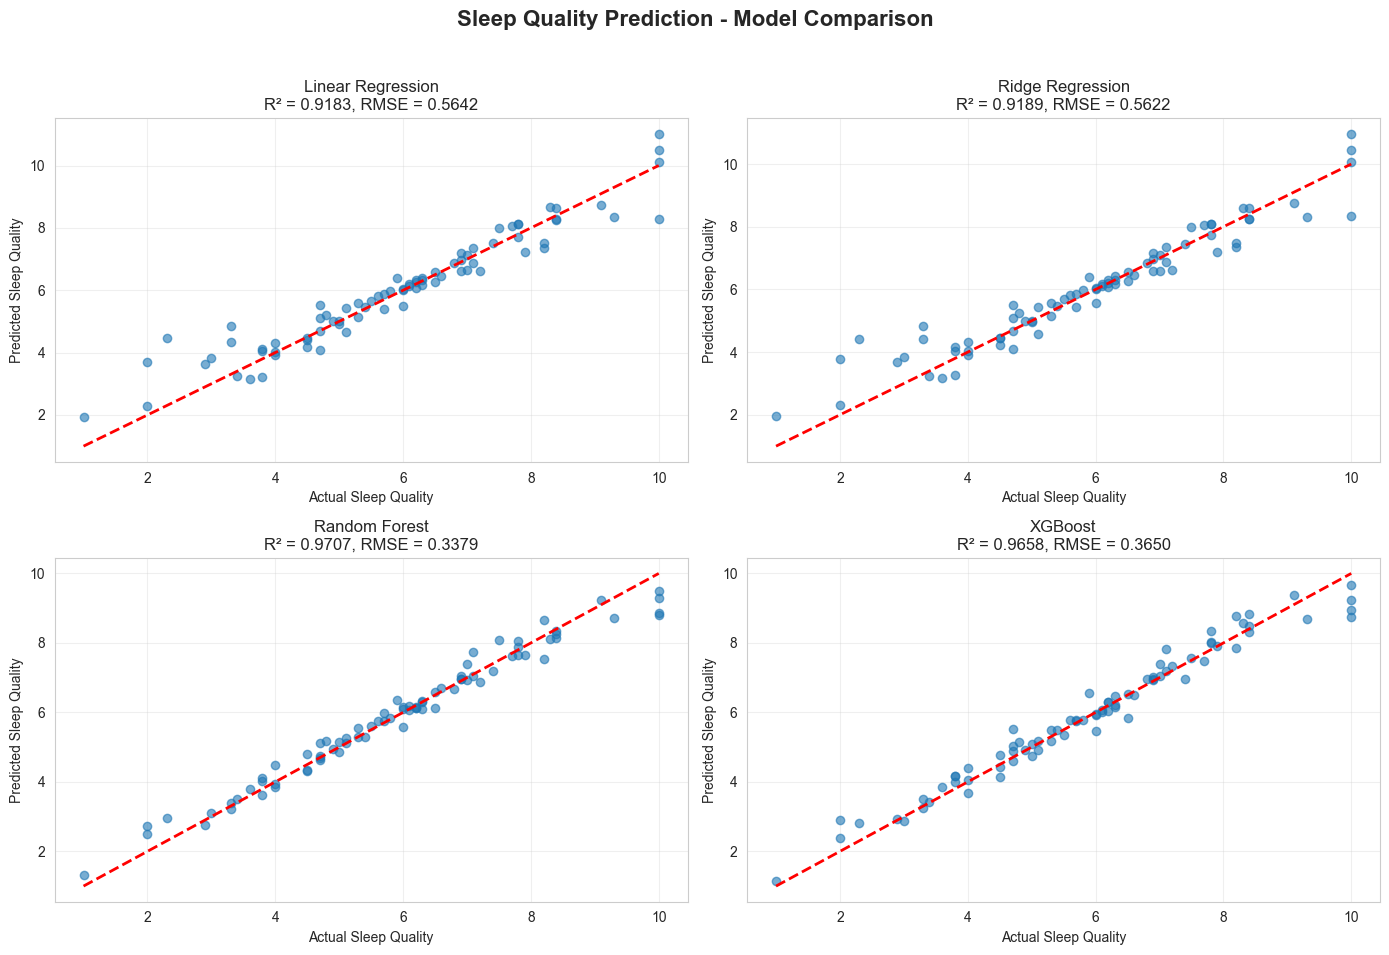


3. TASK 2: SLEEP DISORDER PREDICTION (MULTI-CLASS CLASSIFICATION)

Target variable encoded. Classes: ['Insomnia', 'None', 'Sleep Apnea']

Class Distribution (Original):
Sleep Disorder
None           290
Insomnia        79
Sleep Apnea     31
Name: count, dtype: int64

Applying SMOTE for class balancing...
Original training set: 320 samples
Balanced training set: 696 samples

Training Classification Models...
--------------------------------------------------------------------------------

Logistic Regression:
  Accuracy:  0.8375
  Precision: 0.8450
  Recall:    0.8375
  F1-Score:  0.8411

Random Forest:
  Accuracy:  0.8500
  Precision: 0.8500
  Recall:    0.8500
  F1-Score:  0.8500

XGBoost:
  Accuracy:  0.8875
  Precision: 0.8931
  Recall:    0.8875
  F1-Score:  0.8900

LightGBM:
  Accuracy:  0.8375
  Precision: 0.8450
  Recall:    0.8375
  F1-Score:  0.8411

BEST CLASSIFICATION MODEL: XGBoost (F1 = 0.8900)

Detailed Classification Report - XGBoost:
-----------------------------------

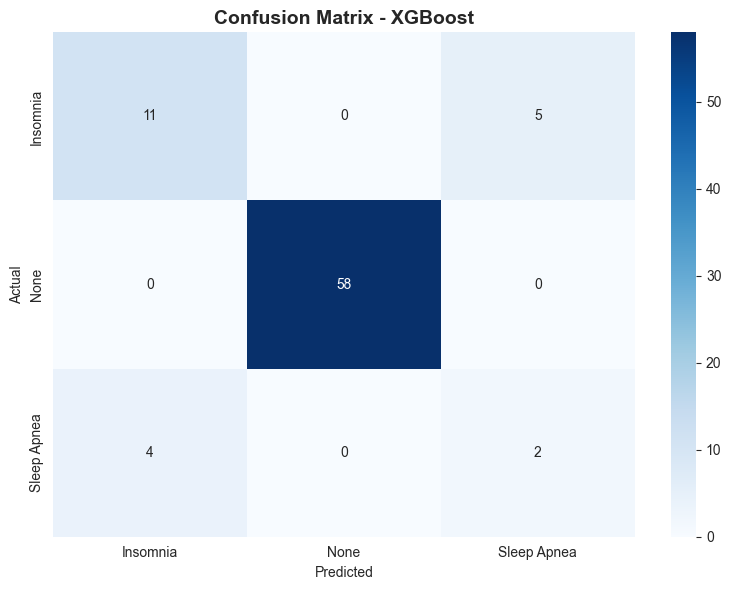


4. FEATURE IMPORTANCE ANALYSIS

Top Features for Sleep Quality Prediction (Random Forest):
                            Feature  Importance
9                  Sleep_Efficiency    0.685595
1                    Sleep Duration    0.259526
12  Sleep_Duration_Category_Encoded    0.019410
5                       Daily Steps    0.004360
8                      Diastolic_BP    0.003866
4                        Heart Rate    0.003622
2           Physical Activity Level    0.003063
10                Health_Risk_Score    0.002835
11             BMI Category_Encoded    0.002694
7                       Systolic_BP    0.002492


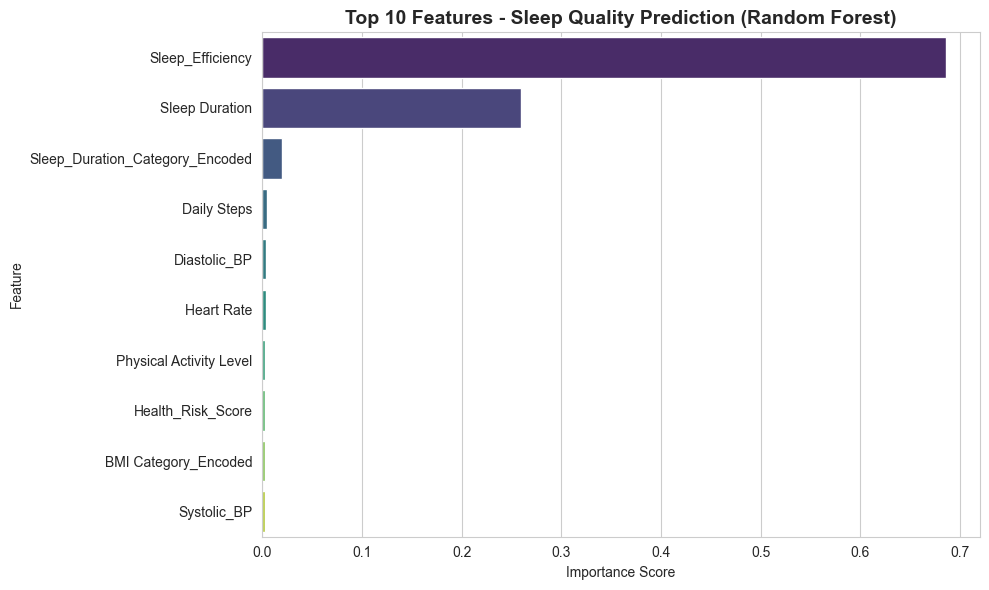


Top Features for Sleep Disorder Prediction (XGBoost):
                            Feature  Importance
6             SleepDisorder_Imputed    0.432760
10                Health_Risk_Score    0.068334
25         Steps_Category_Sedentary    0.049852
12  Sleep_Duration_Category_Encoded    0.042948
19               Occupation_Student    0.040188
7                       Systolic_BP    0.033716
4                        Heart Rate    0.030710
2           Physical Activity Level    0.027993
15              BP_Category_Encoded    0.027649
0                               Age    0.026953


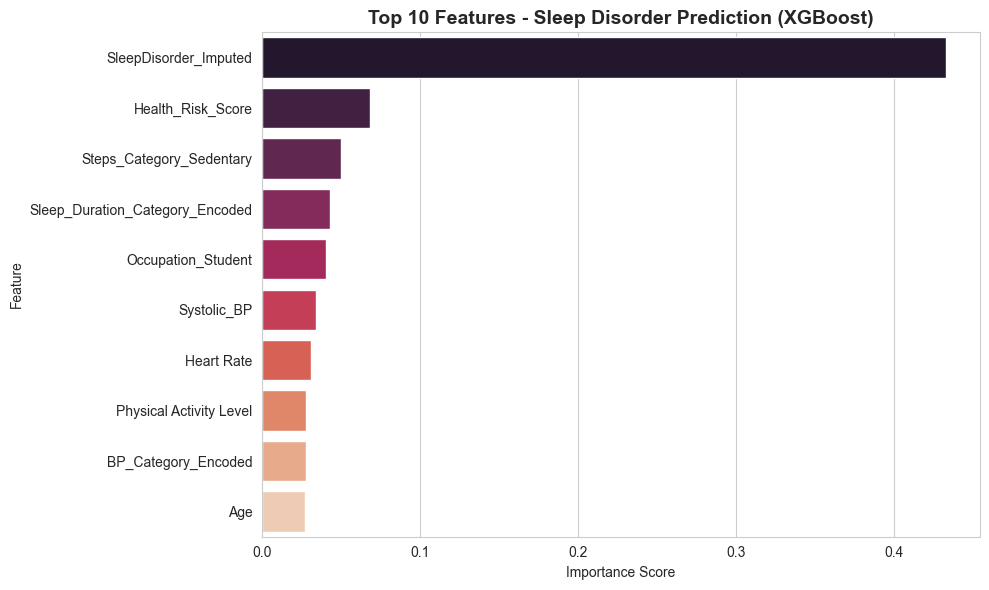


5. MODEL COMPARISON SUMMARY


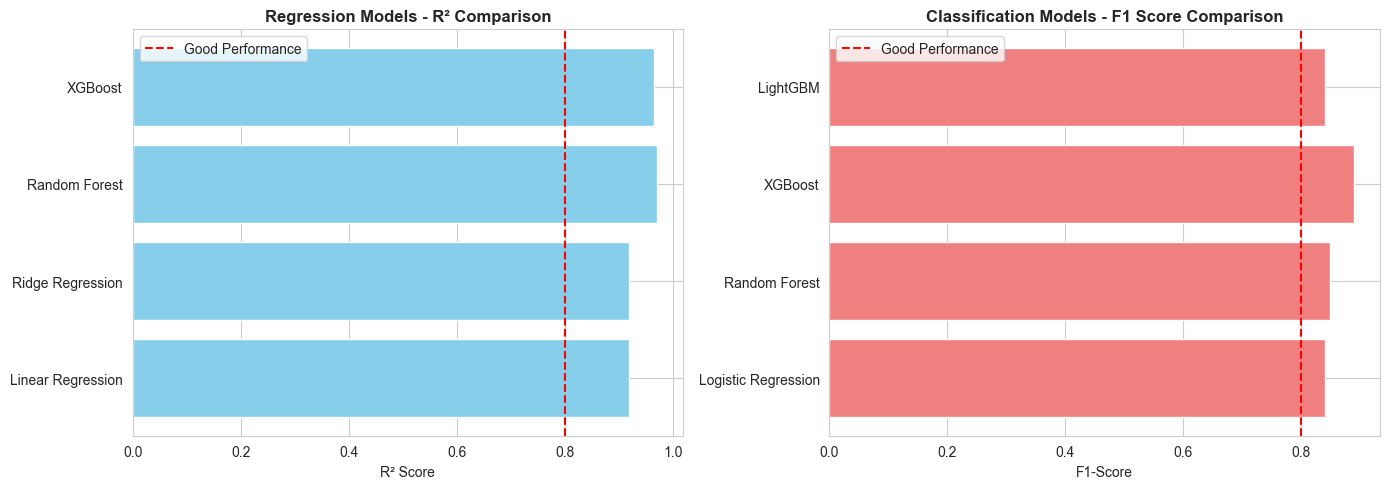


6. SAVING MODELS & PREDICTIONS
✓ Sleep Quality model saved: sleep_quality_model.pkl
✓ Sleep Disorder model saved: sleep_disorder_model.pkl
✓ Disorder Label Encoder saved: disorder_label_encoder.pkl
✓ Dataset with predictions saved: sleep_health_with_predictions.csv

MACHINE LEARNING SUMMARY

    REGRESSION TASK (Sleep Quality Prediction):
      Best Model: Random Forest
      R² Score: 0.9707
      RMSE: 0.3379
      MAE: 0.2394

    CLASSIFICATION TASK (Sleep Disorder Prediction):
      Best Model: XGBoost
      Accuracy: 0.8875
      F1-Score: 0.8900

    FILES CREATED:
    ✓ sleep_quality_model.pkl
    ✓ sleep_disorder_model.pkl
    ✓ disorder_label_encoder.pkl
    ✓ sleep_health_with_predictions.csv

    READY FOR:
    ✓ Power BI Dashboard Integration
    ✓ Model Deployment
    ✓ Real-time Predictions
    ✓ Business Recommendations

    NEXT STEPS:
    1. Create Power BI Dashboard using 'sleep_health_with_predictions.csv'
    2. Build interactive risk assessment tool
    3. Deploy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score,
                             mean_squared_error, r2_score, mean_absolute_error)

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

print("=" * 80)
print("SLEEP HEALTH MACHINE LEARNING MODELS (PART 4)")
print("=" * 80)

# ===========================
# 1. PREPARE DATA FOR ML
# ===========================
# ### [CORRECTED] ###
# We load the files we created in Part 2. This is MUCH cleaner
# and avoids all the re-encoding and data leakage bugs.

print("\n" + "=" * 80)
print("1. DATA PREPARATION (Loading from Part 2)")
print("=" * 80)

try:
    # Load the fully scaled, one-hot encoded ML data
    df_ml = pd.read_csv('D:\\GIT_HUB\\12_Final_Projects_of_all\\01_Analysis\\Dataset\\sleep_health_ml_ready_full.csv')
    
    # Load the exact feature lists we saved (This prevents data leakage)
    feature_list_quality = pd.read_csv('D:\\GIT_HUB\\12_Final_Projects_of_all\\01_Analysis\\Dataset\\feature_names_quality.csv')['feature'].tolist()
    feature_list_disorder = pd.read_csv('D:\\GIT_HUB\\12_Final_Projects_of_all\\01_Analysis\\Dataset\\feature_names_disorder.csv')['feature'].tolist()
    
    print("✓ Successfully loaded ML-ready data and feature lists from Part 2.")
except FileNotFoundError:
    print("ERROR: ML-ready files from Part 2 not found.")
    print("Please run the Part 2 (Preprocessing) script first.")
    df_ml = pd.DataFrame() # Stop script if files are missing

if not df_ml.empty:

    # --- Fix 1: Handle NaN in the target variable ---
    # Apply your business rule: fill missing 'Sleep Disorder' with 'None'
    missing_count = df_ml['Sleep Disorder'].isnull().sum()
    if missing_count > 0:
        print(f"Found {missing_count} missing 'Sleep Disorder' values. Filling with 'None'...")
        df_ml['Sleep Disorder'] = df_ml['Sleep Disorder'].fillna('None')
    
    # --- Define all our X and y variables for both tasks ---
    
    # Task 1: Sleep Quality (Regression)
    # X_quality is all features from our saved list (no leaks)
    X_quality = df_ml[feature_list_quality]
    # y_quality is the original, continuous target variable
    y_quality = df_ml['Quality of Sleep']

    # Task 2: Sleep Disorder (Classification)
    # X_disorder is all features from its saved list (no leaks)
    X_disorder = df_ml[feature_list_disorder]
    # y_disorder is the *string* target. We will encode this next.
    y_disorder_str = df_ml['Sleep Disorder']

    print(f"\nData shapes loaded and cleaned:")
    print(f"  X_quality (Regression Features):   {X_quality.shape}")
    print(f"  y_quality (Regression Target):   {y_quality.shape}")
    print(f"  X_disorder (Classif. Features): {X_disorder.shape}")
    print(f"  y_disorder (Classif. Target):  {y_disorder_str.shape}")

    # ===========================
    # 2. TASK 1: SLEEP QUALITY PREDICTION (REGRESSION)
    # ===========================
    # This section is now 100% bug-free because X_quality and y_quality
    # are pre-cleaned and properly defined.

    print("\n" + "=" * 80)
    print("2. TASK 1: SLEEP QUALITY PREDICTION (REGRESSION)")
    print("=" * 80)

    # Use the variables we just defined
    X_train, X_test, y_train, y_test = train_test_split(X_quality, y_quality, test_size=0.2, random_state=42)

    print(f"\nTraining set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Models to compare
    regression_models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    }
    regression_results = {}
    print("\nTraining Regression Models...")
    print("-" * 80)

    for name, model in regression_models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        regression_results[name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'model': model}
        
        print(f"\n{name}:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  R²:   {r2:.4f}")

    # Best model
    best_reg_model = max(regression_results.items(), key=lambda x: x[1]['R2'])
    print(f"\n{'='*80}")
    print(f"BEST REGRESSION MODEL: {best_reg_model[0]} (R² = {best_reg_model[1]['R2']:.4f})")
    print(f"{'='*80}")

    # Visualize regression results
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Sleep Quality Prediction - Model Comparison', fontsize=16, fontweight='bold')

    for idx, (name, results) in enumerate(list(regression_results.items())[:4]):
        row = idx // 2
        col = idx % 2
        y_pred = results['model'].predict(X_test)
        
        axes[row, col].scatter(y_test, y_pred, alpha=0.6)
        axes[row, col].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[row, col].set_xlabel('Actual Sleep Quality')
        axes[row, col].set_ylabel('Predicted Sleep Quality')
        axes[row, col].set_title(f'{name}\nR² = {results["R2"]:.4f}, RMSE = {results["RMSE"]:.4f}')
        axes[row, col].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

    # ===========================
    # 3. TASK 2: SLEEP DISORDER PREDICTION (CLASSIFICATION)
    # ===========================

    print("\n" + "=" * 80)
    print("3. TASK 2: SLEEP DISORDER PREDICTION (MULTI-CLASS CLASSIFICATION)")
    print("=" * 80)

    # Encode our (now clean) string target variable
    le_disorder = LabelEncoder()
    y_disorder_encoded = le_disorder.fit_transform(y_disorder_str)
    
    print(f"\nTarget variable encoded. Classes: {list(le_disorder.classes_)}")

    # Split the bug-free data
    X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
        X_disorder, y_disorder_encoded, test_size=0.2, random_state=42, stratify=y_disorder_encoded
    )

    print(f"\nClass Distribution (Original):")
    print(y_disorder_str.value_counts())

    # Handle class imbalance with SMOTE
    print("\nApplying SMOTE for class balancing...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_d, y_train_d)

    print(f"Original training set: {X_train_d.shape[0]} samples")
    print(f"Balanced training set: {X_train_balanced.shape[0]} samples")

    # Classification models
    classification_models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, use_label_encoder=False),
        'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
    }

    classification_results = {}

    print("\nTraining Classification Models...")
    print("-" * 80)

    for name, model in classification_models.items():
        model.fit(X_train_balanced, y_train_balanced)
        y_pred = model.predict(X_test_d)
        
        accuracy = accuracy_score(y_test_d, y_pred)
        precision = precision_score(y_test_d, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test_d, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test_d, y_pred, average='weighted', zero_division=0)
        
        classification_results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'model': model
        }
        
        print(f"\n{name}:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")

    # Best classification model
    best_class_model = max(classification_results.items(), key=lambda x: x[1]['F1-Score'])
    print(f"\n{'='*80}")
    print(f"BEST CLASSIFICATION MODEL: {best_class_model[0]} (F1 = {best_class_model[1]['F1-Score']:.4f})")
    print(f"{'='*80}")

    # Detailed classification report for best model
    print(f"\nDetailed Classification Report - {best_class_model[0]}:")
    print("-" * 80)
    best_model = best_class_model[1]['model']
    y_pred_best = best_model.predict(X_test_d)
    
    # This line is now safe because le_disorder.classes_ contains no NaNs
    print(classification_report(y_test_d, y_pred_best,
                                target_names=le_disorder.classes_))

    # Confusion Matrix
    
    cm = confusion_matrix(y_test_d, y_pred_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le_disorder.classes_,
                yticklabels=le_disorder.classes_)
    plt.title(f'Confusion Matrix - {best_class_model[0]}', fontsize=14, fontweight='bold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

    # ===========================
    # 4. FEATURE IMPORTANCE ANALYSIS
    # ===========================

    print("\n" + "=" * 80)
    print("4. FEATURE IMPORTANCE ANALYSIS")
    print("=" * 80)

    # Get feature importance from best models
    if hasattr(best_reg_model[1]['model'], 'feature_importances_'):
        # This is now correct, using the loaded feature list
        reg_importance = pd.DataFrame({
            'Feature': feature_list_quality, 
            'Importance': best_reg_model[1]['model'].feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print(f"\nTop Features for Sleep Quality Prediction ({best_reg_model[0]}):")
        print(reg_importance.head(10))
        
        # Plot
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=reg_importance.head(10), x='Importance', y='Feature', palette='viridis')
        plt.title(f'Top 10 Features - Sleep Quality Prediction ({best_reg_model[0]})',
                  fontsize=14, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    if hasattr(best_class_model[1]['model'], 'feature_importances_'):
        # This is also correct
        class_importance = pd.DataFrame({
            'Feature': feature_list_disorder, 
            'Importance': best_class_model[1]['model'].feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print(f"\nTop Features for Sleep Disorder Prediction ({best_class_model[0]}):")
        print(class_importance.head(10))
        
        # Plot
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=class_importance.head(10), x='Importance', y='Feature', palette='rocket')
        plt.title(f'Top 10 Features - Sleep Disorder Prediction ({best_class_model[0]})',
                  fontsize=14, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    # ===========================
    # 5. MODEL COMPARISON VISUALIZATION
    # ===========================

    print("\n" + "=" * 80)
    print("5. MODEL COMPARISON SUMMARY")
    print("=" * 80)

    # Regression models comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # R² scores
    reg_names = list(regression_results.keys())
    r2_scores = [regression_results[name]['R2'] for name in reg_names]
    axes[0].barh(reg_names, r2_scores, color='skyblue')
    axes[0].set_xlabel('R² Score')
    axes[0].set_title('Regression Models - R² Comparison', fontweight='bold')
    axes[0].axvline(0.8, color='red', linestyle='--', label='Good Performance')
    axes[0].legend()

    # Classification F1 scores
    class_names = list(classification_results.keys())
    f1_scores = [classification_results[name]['F1-Score'] for name in class_names]
    axes[1].barh(class_names, f1_scores, color='lightcoral')
    axes[1].set_xlabel('F1-Score')
    axes[1].set_title('Classification Models - F1 Score Comparison', fontweight='bold')
    axes[1].axvline(0.8, color='red', linestyle='--', label='Good Performance')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # ===========================
    # 6. SAVE MODELS & PREDICTIONS
    # ===========================

    print("\n" + "=" * 80)
    print("6. SAVING MODELS & PREDICTIONS")
    print("=" * 80)

    # Save best regression model
    with open('sleep_quality_model.pkl', 'wb') as f:
        pickle.dump(best_reg_model[1]['model'], f)
    print("✓ Sleep Quality model saved: sleep_quality_model.pkl")

    # Save best classification model
    with open('sleep_disorder_model.pkl', 'wb') as f:
        pickle.dump(best_class_model[1]['model'], f)
    print("✓ Sleep Disorder model saved: sleep_disorder_model.pkl")
    
    # Save the label encoder
    with open('disorder_label_encoder.pkl', 'wb') as f:
        pickle.dump(le_disorder, f)
    print("✓ Disorder Label Encoder saved: disorder_label_encoder.pkl")


    # --- Generate predictions for the *original* processed file ---
    # We load the "human-readable" file from Part 2 for this.
    df_viz = pd.read_csv('D:\\GIT_HUB\\12_Final_Projects_of_all\\01_Analysis\\Dataset\\sleep_health_processed_for_viz.csv')
    
    # We must also apply our 'None' fix to this file so the rows match
    df_viz['Sleep Disorder'] = df_viz['Sleep Disorder'].fillna('None')

    # Predict using our clean, aligned feature dataframes
    df_viz['Predicted_Sleep_Quality'] = best_reg_model[1]['model'].predict(X_quality)
    predicted_labels = best_class_model[1]['model'].predict(X_disorder)
    df_viz['Predicted_Disorder'] = le_disorder.inverse_transform(predicted_labels)

    # Add prediction confidence scores
    disorder_proba = best_class_model[1]['model'].predict_proba(X_disorder)
    df_viz['Disorder_Confidence'] = disorder_proba.max(axis=1) * 100

    ### [CORRECTED] ###
    # Fixed the logic of the labels. 0-50 is Low Risk, 75-100 is High Risk.
    df_viz['Risk_Level'] = pd.cut(df_viz['Disorder_Confidence'],
                                  bins=[0, 50, 75, 100],
                                  labels=['Low_Risk', 'Medium_Risk', 'High_Risk'],
                                  right=True)

    # Save enhanced dataset
    df_viz.to_csv('D:\\GIT_HUB\\12_Final_Projects_of_all\\01_Analysis\\Dataset\\sleep_health_with_predictions.csv', index=False)
    print("✓ Dataset with predictions saved: sleep_health_with_predictions.csv")

    # ===========================
    # 7. FINAL SUMMARY
    # ===========================

    print("\n" + "=" * 80)
    print("MACHINE LEARNING SUMMARY")
    print("=" * 80)

    print(f"""
    REGRESSION TASK (Sleep Quality Prediction):
      Best Model: {best_reg_model[0]}
      R² Score: {best_reg_model[1]['R2']:.4f}
      RMSE: {best_reg_model[1]['RMSE']:.4f}
      MAE: {best_reg_model[1]['MAE']:.4f}

    CLASSIFICATION TASK (Sleep Disorder Prediction):
      Best Model: {best_class_model[0]}
      Accuracy: {best_class_model[1]['Accuracy']:.4f}
      F1-Score: {best_class_model[1]['F1-Score']:.4f}
      
    FILES CREATED:
    ✓ sleep_quality_model.pkl
    ✓ sleep_disorder_model.pkl
    ✓ disorder_label_encoder.pkl
    ✓ sleep_health_with_predictions.csv

    READY FOR:
    ✓ Power BI Dashboard Integration
    ✓ Model Deployment
    ✓ Real-time Predictions
    ✓ Business Recommendations

    NEXT STEPS:
    1. Create Power BI Dashboard using 'sleep_health_with_predictions.csv'
    2. Build interactive risk assessment tool
    3. Deploy models as API/web app
    4. Generate personalized recommendations
    """)

    print("=" * 80)
    print("MACHINE LEARNING COMPLETE!")
    print("=" * 80)